In [1]:
import pickle
import torch
import os
import copy
import numpy as np
import matplotlib.pyplot as plt

from torch_geometric.data import InMemoryDataset, Data, DataLoader
from torch_geometric.utils import to_undirected
from rdkit import Chem
from rdkit.Chem.rdchem import Atom, Bond, RingInfo
from rdkit.Chem.rdDistGeom import EmbedMolecule, EmbedMultipleConfs
from typing import List
from ConformationEnsemble import ConformationEnsembleLibrary, ConformationEnsemble
from tqdm import tqdm
from rdkit.Chem.rdMolAlign import GetBestRMS
from ccdc.conformer import ConformerGenerator
from ccdc.molecule import Molecule
from ccdc.descriptors import MolecularDescriptors
from rdkit.Geometry.rdGeometry import Point3D
from rdkit.Chem.TorsionFingerprints import GetTFDBetweenConformers
from rdkit.Chem.TorsionFingerprints import CalculateTorsionLists
from rdkit.Chem.rdMolTransforms import GetDihedralDeg, SetDihedralDeg
from collections import defaultdict
from torch_geometric.data import Batch

In [2]:
from ipywidgets import interact,fixed,IntSlider
import ipywidgets
import py3Dmol

In [3]:
data_dir_path = 'data/'
with open(os.path.join(data_dir_path, 'pdbbind_refined_mol_list.p'), 'rb') as f :
    refined_mols = pickle.load(f)

In [4]:
def featurize_mol(mol, conf_generator='ccdc', rmsd_func='ccdc') :
    
    pdbbind_encoder_path = os.path.join('data', 'pdbbind_molecule_encoders.p')
    
    if os.path.exists(pdbbind_encoder_path) : # Load existing
        with open(pdbbind_encoder_path, 'rb') as f:
            encoders = pickle.load(f)
    
    encoded_atom_functions = [Atom.GetAtomicNum, Atom.GetDegree, Atom.GetHybridization, 
                                       Atom.GetChiralTag, Atom.GetImplicitValence, Atom.GetFormalCharge]
    encoded_bond_functions = [Bond.GetBondType]
    encoded_ring_functions = [RingInfo.NumAtomRings]
    
    ccdc_conformer_generator = ConformerGenerator()
    
    data_list = []

    rdkit_mol = copy.deepcopy(mol)

    # Generate conformations
    n_conf = rdkit_mol.GetNumConformers()
    bioactive_conf_ids = [conf.GetId() for conf in rdkit_mol.GetConformers()]
    n_bioactive_confs = len(bioactive_conf_ids)
    n_conf_to_generate = max(1, int((50 - n_bioactive_confs) / (n_bioactive_confs + 1)))
    torsions = [torsion_hit[0][0] for torsion_hit in CalculateTorsionLists(rdkit_mol)[0]]

    if conf_generator == 'rdkit' :
        rdkit_conf_ids = EmbedMultipleConfs(rdkit_mol, n_conf_to_generate, clearConfs=False)
    elif conf_generator == 'ccdc' :
        mol2_block = Chem.MolToMolBlock(rdkit_mol)

        ccdc_mol = Molecule.from_string(mol2_block)
        ccdc_conformer_generator.settings.max_conformers = n_conf_to_generate
        ccdc_conformers = ccdc_conformer_generator.generate(ccdc_mol)

        generated_conf_ids = ccdc_conformers_to_rdkit_mol(rdkit_mol, ccdc_conformers, exclude_hydrogens=True)

        torsion_values = defaultdict(list)
        for bioactive_conf_id in bioactive_conf_ids :
            bioactive_conf = rdkit_mol.GetConformer(bioactive_conf_id)
            for generated_conf_id in generated_conf_ids :
                generated_conf = rdkit_mol.GetConformer(generated_conf_id)

                dummy_mol = copy.deepcopy(rdkit_mol)
                new_conf = dummy_mol.GetConformer()
                for torsion_atoms in torsions :
                    bioactive_dihedral = GetDihedralDeg(bioactive_conf, *torsion_atoms)
                    generated_dihedral = GetDihedralDeg(generated_conf, *torsion_atoms)
                    interpolated_dihedral = angle_interpolation(bioactive_dihedral, generated_dihedral)

                    SetDihedralDeg(new_conf, *torsion_atoms, interpolated_dihedral[0])

                rdkit_mol.AddConformer(new_conf, assignId=True)

    rdkit_mol = Chem.RemoveHs(rdkit_mol)

    # Encode atom features
    mol_atom_features = []
    ring = rdkit_mol.GetRingInfo()
    for atom_idx, atom in enumerate(rdkit_mol.GetAtoms()):
        atom_features = []

        # Add one hot encoding of atomic features
        for function in encoded_atom_functions :
            function_name = f'{function.__module__}.{function.__name__}'
            encoder = encoders[function_name]
            value = function(atom)
            atom_features.extend(encoder(value))

        atom_features.append(atom.GetAtomicNum()) # Atomic number is both encoded as one hot and integer
        atom_features.append(1 if atom.GetIsAromatic() else 0)

        atom_features.extend([atom.IsInRingSize(size) for size in range(3, 9)])

        # Add one hot encoding of ring features in atomic features
        for function in encoded_ring_functions :
            function_name = f'{function.__module__}.{function.__name__}'
            encoder = encoders[function_name]
            value = function(ring, atom_idx)
            atom_features.extend(encoder(value))

        mol_atom_features.append(atom_features)

    x = torch.tensor(mol_atom_features, dtype=torch.float32)

    # Encode bond features
    mol_bond_features = []
    row = []
    col = []
    for bond in rdkit_mol.GetBonds(): # bonds are undirect, while torch geometric data has directed edge
        bond_features = []
        start, end = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()
        row.append(start)
        col.append(end)

        # Add one hot encoding of bond features
        for function in encoded_bond_functions :
            function_name = f'{function.__module__}.{function.__name__}'
            encoder = encoders[function_name]
            value = function(bond)
            bond_features.extend(encoder(value))

        bond_features.append(int(bond.IsInRing()))
        bond_features.append(int(bond.GetIsConjugated()))
        bond_features.append(int(bond.GetIsAromatic()))

        mol_bond_features.append(bond_features)

    # Directed graph to undirected
    row, col = row + col, col + row
    edge_index = torch.tensor([row, col])
    edge_attr = torch.tensor(mol_bond_features + mol_bond_features, dtype=torch.float32)

    # Sort the edge by source node idx
    perm = (edge_index[0] * rdkit_mol.GetNumAtoms() + edge_index[1]).argsort()
    edge_index = edge_index[:, perm]
    edge_attr = edge_attr[perm]

    # Make one data per conformer, because it has different positions
    for conf_id, conf in enumerate(rdkit_mol.GetConformers()) :

        data = conf_to_data(rdkit_mol, conf_id, bioactive_conf_ids, x, edge_index, edge_attr, rmsd_func)
        data_list.append(data)

    return data_list

def conf_to_data(rdkit_mol, conf_id, bioactive_conf_ids, x, edge_index, edge_attr, rmsd_func) :
    
    conf = rdkit_mol.GetConformer(conf_id)
    # Keep only the conformer encoded in by the positions
    dummy_mol = copy.deepcopy(rdkit_mol)
    dummy_mol.RemoveAllConformers()
    dummy_mol.AddConformer(rdkit_mol.GetConformer(conf_id))

    pos = torch.tensor(conf.GetPositions(), dtype=torch.float32)

    if conf_id in bioactive_conf_ids :
        rmsd = 1e-6
        tfd = 1e-6
    else :
        rmsds_to_bioactive = []
        tfds_to_bioactive = []
        for bioactive_conf_id in bioactive_conf_ids :

            if rmsd_func == 'ccdc' :
                tested_molblock = Chem.MolToMolBlock(rdkit_mol, confId=conf_id)
                bioactive_molblock = Chem.MolToMolBlock(rdkit_mol, confId=bioactive_conf_id)
                tested_ccdc_mol = Molecule.from_string(tested_molblock)
                bioactive_ccdc_mol = Molecule.from_string(bioactive_molblock)
                rmsd = MolecularDescriptors.overlay_rmsds_and_transformation(tested_ccdc_mol, bioactive_ccdc_mol)[1]
            else :
                rmsd = GetBestRMS(rdkit_mol, rdkit_mol, conf_id, bioactive_conf_id, maxMatches=1000)

            rmsds_to_bioactive.append(rmsd)

            tfd = GetTFDBetweenConformers(rdkit_mol, [conf_id], [bioactive_conf_id])[0]
            tfds_to_bioactive.append(tfd)

        rmsd = min(rmsds_to_bioactive)
        tfd = min(tfds_to_bioactive)

    if tfd > 1 : # weird molecule
        print(tfd)
        print(Chem.MolToSmiles(dummy_mol))
        tfd = 1

    #y = 1 if ('PDB_ID' in conf.GetPropsAsDict()) else 0
    rmsd = torch.tensor([rmsd], dtype=torch.float32)
    tfd = torch.tensor([tfd], dtype=torch.float32)

    #data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, pos=pos, mol=dummy_mol, y=y)
    data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, pos=pos, rmsd=rmsd, tfd=tfd, smiles=Chem.MolToSmiles(dummy_mol))
    return data

def ccdc_conformers_to_rdkit_mol(rdkit_mol, ccdc_conformers, exclude_hydrogens=True) :

    generated_conf_ids = []

    for conformer in ccdc_conformers :
        temp_rdkit_mol = copy.deepcopy(rdkit_mol)
        new_rdkit_conf = temp_rdkit_mol.GetConformer()
        ccdc_conformer_atoms = conformer.molecule.atoms
        if exclude_hydrogens :
            # conformer_ccdc_molecule.remove_hydrogens() # doesnt work
            ccdc_conformer_atoms = [atom for atom in ccdc_conformer_atoms if atom.atomic_symbol != 'H']
        for i, atom in enumerate(ccdc_conformer_atoms) :
            atom_coord = [coord for coord in atom.coordinates]
            point3d = Point3D(*atom_coord)
            new_rdkit_conf.SetAtomPosition(i, point3d)
        conf_id = rdkit_mol.AddConformer(new_rdkit_conf, assignId=True)
        generated_conf_ids.append(conf_id)

    return generated_conf_ids

def angle_interpolation(start, end, amounts=[0.5]) :
    interps = []
    for amount in amounts :
        shortest_angle = ((((end - start) % 360) + 540) % 360) - 180
        to_add = shortest_angle * amount
        interps.append((((start + to_add) + 180) % 360) - 180)
    return interps

In [5]:
import pytorch_lightning as pl
from torch_geometric.nn.models import SchNet
class LitSchNet(pl.LightningModule):
    def __init__(self, task='rmsd'):
        super().__init__()
        self.schnet = SchNet()
        self.leaky_relu = torch.nn.LeakyReLU()
        self.sigmoid = torch.nn.Sigmoid()
        
        assert task in ['rmsd', 'tfd']
        self.task = task

    def forward(self, batch):
        pred = self.schnet(batch.x[:,56].long(), batch.pos, batch.batch)
        if self.task == 'rmsd' :
            pred = self.leaky_relu(pred)
        elif self.task == 'tfd' :
            pred = self.sigmoid(pred)
        return pred

    def training_step(self, batch, batch_idx):
        pred = self.forward(batch)
        target = self._get_target(batch)
        loss = F.mse_loss(pred.squeeze(), target)
        self.log("train_loss", loss)
        return loss
    
    def validation_step(self, batch, batch_idx):
        pred = self.forward(batch)
        target = self._get_target(batch)
        loss = F.mse_loss(pred.squeeze(), target)
        self.log("val_loss", loss)
        return loss
    
    def test_step(self, batch, batch_idx):
        pred = self.forward(batch)
        target = self._get_target(batch)
        loss = F.mse_loss(pred.squeeze(), target)
        self.log("test_loss", loss)
        return loss

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=1e-4)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer)
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "monitor": "val_loss",
                "frequency": 1
                # If "monitor" references validation metrics, then "frequency" should be set to a
                # multiple of "trainer.check_val_every_n_epoch".
            },
        }
    
    def _get_target(self, batch) :
        if self.task == 'rmsd' :
            return batch.rmsd
        elif self.task == 'tfd' :
            return batch.tfd

In [6]:
def data_list_to_conf_ensemble(data_list, mol) :
    new_mol = copy.deepcopy(mol)
    n_gen = len(data_list) - mol.GetNumConformers()
    for data in data_list[-n_gen:] :
        dummy_mol = copy.deepcopy(mol)
        new_conf = dummy_mol.GetConformer()
        for ai, pos in enumerate(new_conf.GetPositions()) :
            point3d = Point3D(*data.pos[ai].numpy().tolist())
            new_conf.SetAtomPosition(ai, point3d)
        new_mol.AddConformer(new_conf, assignId=True)
    return new_mol

In [7]:
def MolTo3DView(mol, confId=-1, size=(300, 300), style="stick", surface=False, opacity=0.5):
    """Draw molecule in 3D
    
    Args:
    ----
        mol: rdMol, molecule to show
        size: tuple(int, int), canvas size
        style: str, type of drawing molecule
               style can be 'line', 'stick', 'sphere', 'carton'
        surface, bool, display SAS
        opacity, float, opacity of surface, range 0.0-1.0
    Return:
    ----
        viewer: py3Dmol.view, a class for constructing embedded 3Dmol.js views in ipython notebooks.
    """
    assert style in ('line', 'stick', 'sphere', 'carton')
    mblock = Chem.MolToMolBlock(mol, confId=confId)
    viewer = py3Dmol.view(width=size[0], height=size[1])
    viewer.addModel(mblock, 'mol')
    viewer.setStyle({style:{}})
    if surface:
        viewer.addSurface(py3Dmol.SAS, {'opacity': opacity})
    viewer.zoomTo()
    return viewer

In [8]:
litschnet = LitSchNet.load_from_checkpoint('lightning_logs/scaffold_split/checkpoints/epoch=5-step=82511.ckpt')

In [9]:
def explore_torsion_space(mol, litschnet) :
    data_list = featurize_mol(mol=mol)
    batch = Batch.from_data_list(data_list)
    pred_rmsd = litschnet(batch)
    plt.scatter(batch.rmsd, pred_rmsd.detach())
    plt.xlabel('Bioactive RMSD')
    plt.ylabel('Predicted RMSD')
    plt.show()
    
    new_mol = data_list_to_conf_ensemble(data_list, mol)
    
    rdkit_mol = new_mol

    def conf_viewer(idx):
        return MolTo3DView(rdkit_mol, idx).show()

    interact(conf_viewer, idx=ipywidgets.IntSlider(min=0,max=rdkit_mol.GetNumConformers() - 1, step=1))
    
    new_data = conf_to_data(new_mol, 15, range(mol.GetNumConformers()), batch.x[0], batch.edge_index[0], batch.edge_attr[0], 'ccdc')
    
    torsions = [torsion_hit[0][0] for torsion_hit in CalculateTorsionLists(mol)[0]]
    
    n_gen = new_mol.GetNumConformers() - mol.GetNumConformers()
    for torsion_atoms in torsions :
        angles = range(-180, 180, 1)
        explore_data_list = []
        for angle in angles :
            dummy_mol = copy.deepcopy(mol) 
            conf = dummy_mol.GetConformer(0)
            SetDihedralDeg(conf, *torsion_atoms, angle)
            data = conf_to_data(dummy_mol, 0, range(mol.GetNumConformers()), data_list[0].x, data_list[0].edge_index, data_list[0].edge_attr, 'ccdc')
            explore_data_list.append(data)

        loader = DataLoader(explore_data_list, batch_size=24)
        pred_rmsd = []
        for batch in loader :
            pred = litschnet(batch)
            pred_rmsd.extend(pred.detach().numpy().tolist())

        plt.figure(figsize=(10,5))
        plt.scatter(angles, pred_rmsd)
        plt.xlabel('Torsion angle')
        plt.ylabel('Predicted RMSD')
        plt.axvline(GetDihedralDeg(mol.GetConformer(0), *torsion_atoms))
        for conf in new_mol.GetConformers()[-n_gen:] :
            plt.axvline(GetDihedralDeg(conf, *torsion_atoms), c='red')
        plt.show()

In [11]:
def explore_torsion_space_2d(mol, litschnet) :
    data_list = featurize_mol(mol=mol)
    batch = Batch.from_data_list(data_list)
    pred_rmsd = litschnet(batch)
    plt.scatter(batch.rmsd, pred_rmsd.detach())
    plt.xlabel('Bioactive RMSD')
    plt.ylabel('Predicted RMSD')
    plt.show()
    
    new_mol = data_list_to_conf_ensemble(data_list, mol)
    
    rdkit_mol = new_mol

    def conf_viewer(idx):
        return MolTo3DView(rdkit_mol, idx).show()

    interact(conf_viewer, idx=ipywidgets.IntSlider(min=0,max=rdkit_mol.GetNumConformers() - 1, step=1))
    
    new_data = conf_to_data(new_mol, 15, range(mol.GetNumConformers()), batch.x[0], batch.edge_index[0], batch.edge_attr[0], 'ccdc')
    
    torsions = [torsion_hit[0][0] for torsion_hit in CalculateTorsionLists(mol)[0]]
    
    n_gen = new_mol.GetNumConformers() - mol.GetNumConformers()
    for i, torsion_atoms1 in enumerate(torsions) :
        for torsion_atoms2 in torsions[i+1:] :
            angles = list(range(-180, 180, 5))
            explore_data_list = []
            for angle1 in angles :
                for angle2 in angles :
                    dummy_mol = copy.deepcopy(mol) 
                    conf = dummy_mol.GetConformer(0)
                    SetDihedralDeg(conf, *torsion_atoms1, angle1)
                    SetDihedralDeg(conf, *torsion_atoms2, angle2)
                    data = conf_to_data(dummy_mol, 0, range(mol.GetNumConformers()), data_list[0].x, data_list[0].edge_index, data_list[0].edge_attr, 'ccdc')
                    explore_data_list.append(data)
                
            loader = DataLoader(explore_data_list, batch_size=24)
            pred_rmsd = []
            for batch in loader :
                pred = litschnet(batch)
                pred_rmsd.extend(pred.detach().numpy().tolist())
                
            pred_rmsd = np.array(pred_rmsd).reshape(len(angles), len(angles))

            fig = plt.figure(figsize=(10,5))
            ax = fig.add_subplot(111)
            cax = ax.matshow(pred_rmsd, extent=[-180, 180, -180, 180])
            fig.colorbar(cax)
            plt.xlabel('Angle1')
            plt.ylabel('Angle2')
            real_torsion1 = GetDihedralDeg(mol.GetConformer(0), *torsion_atoms1)
            real_torsion2 = GetDihedralDeg(mol.GetConformer(0), *torsion_atoms2)
            ax.set_title(f'{torsion_atoms1} : {int(real_torsion1)} X {torsion_atoms2} : {int(real_torsion2)}')
            plt.show()

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


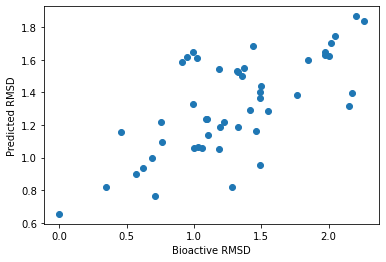

/home/benoit/anaconda3/envs/GeoMol/lib/python3.7/site-packages/ipykernel/pylab/backend_inline.py:14: DeprecationWarning: `ipykernel.pylab.backend_inline` is deprecated, directly use `matplotlib_inline.backend_inline`
  DeprecationWarning


interactive(children=(IntSlider(value=0, description='idx', max=48), Output()), _dom_classes=('widget-interact…

/home/benoit/anaconda3/envs/GeoMol/lib/python3.7/site-packages/torch_geometric/deprecation.py:13: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


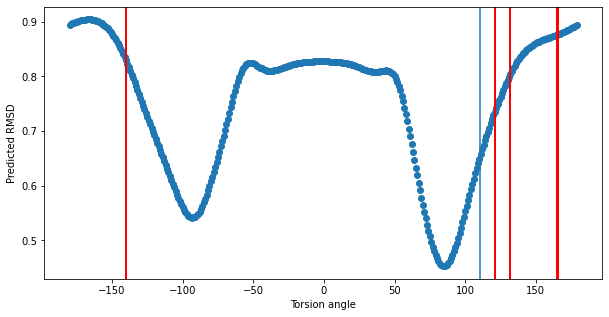

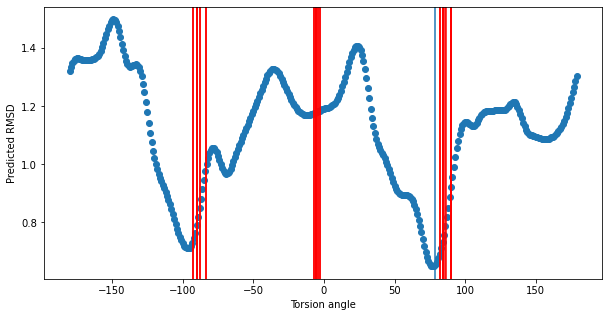

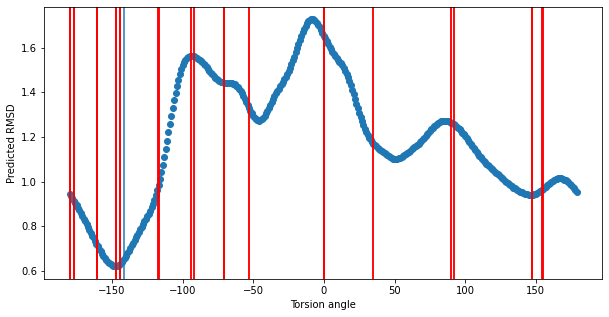

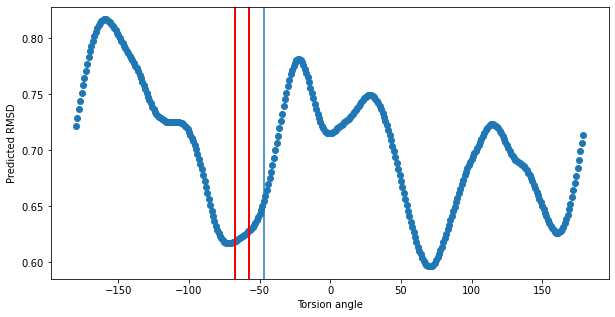

In [10]:
mol = refined_mols[1]
explore_torsion_space(mol, litschnet)

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


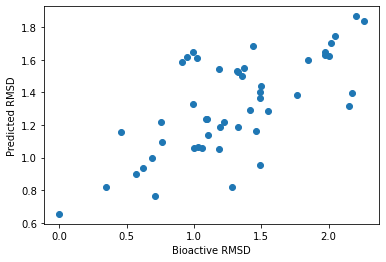

interactive(children=(IntSlider(value=0, description='idx', max=48), Output()), _dom_classes=('widget-interact…

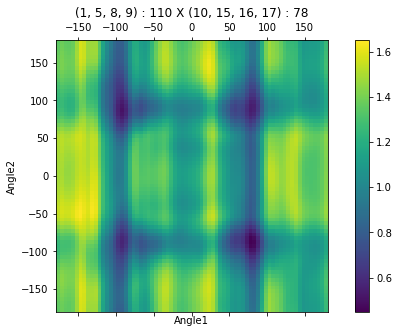

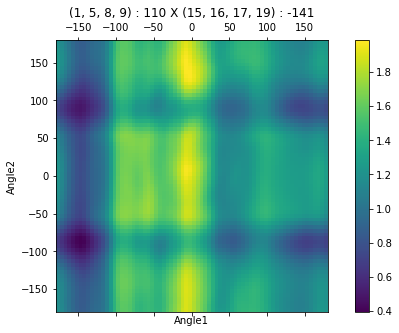

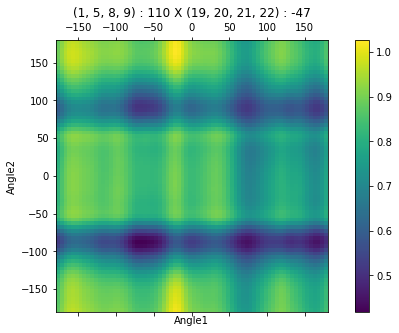

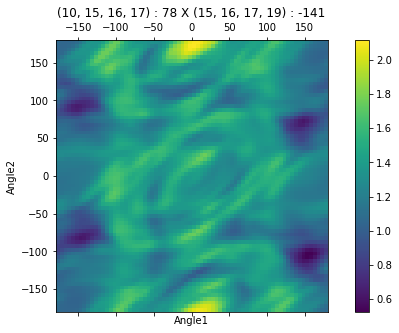

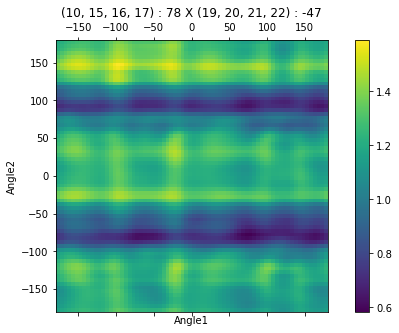

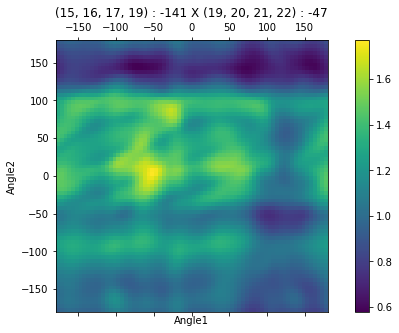

In [12]:
mol = refined_mols[1]
explore_torsion_space_2d(mol, litschnet)

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


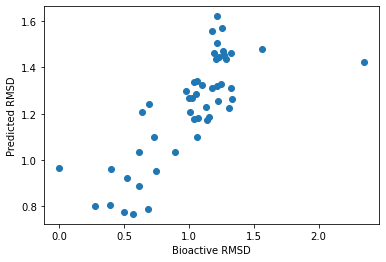

interactive(children=(IntSlider(value=0, description='idx', max=48), Output()), _dom_classes=('widget-interact…

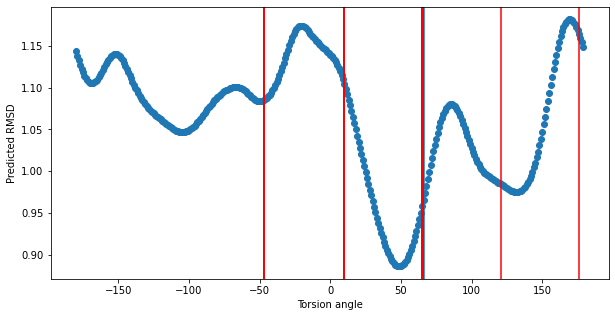

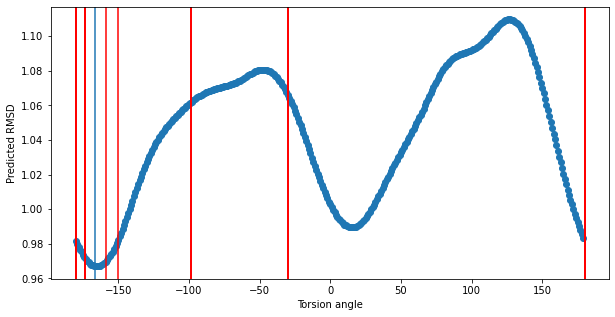

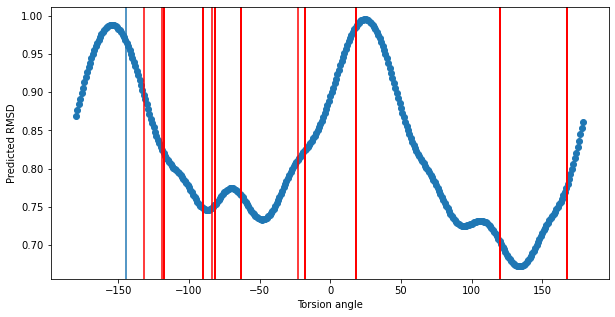

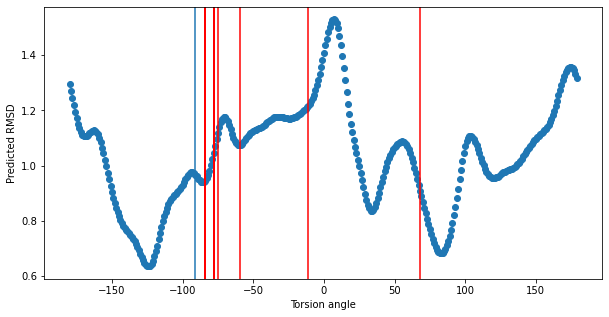

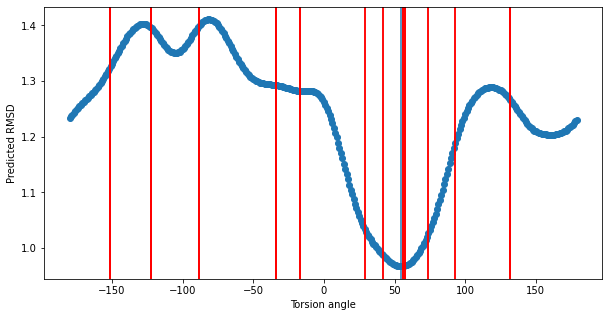

In [12]:
mol = refined_mols[2]
explore_torsion_space(mol, litschnet)

In [13]:
conf_to_data(rdkit_mol, conf_id, bioactive_conf_ids, x, edge_index, edge_attr, rmsd_func)

NameError: name 'rdkit_mol' is not defined

In [14]:
def scoring_function(inputs, data_list, dummy_mol, torsions) :
    conf = dummy_mol.GetConformer(0)
    for i, input in enumerate(inputs) :
        SetDihedralDeg(conf, *torsions[i], input)
    data = conf_to_data(rdkit_mol=dummy_mol, 
                        conf_id=0, 
                        bioactive_conf_ids=range(mol.GetNumConformers()), 
                        x=data_list[0].x, 
                        edge_index=data_list[0].edge_index, 
                        edge_attr=data_list[0].edge_attr, 
                        rmsd_func='ccdc')
    data_list = [data]
    batch = Batch.from_data_list(data_list)
    pred_rmsd = litschnet(batch).detach().numpy()
    output = pred_rmsd[0][0]
    return output

In [15]:
from scipy.optimize import minimize

In [16]:
def ccdc_rmsd_rdkit_mol(rdkit_mol, conf_id1, conf_id2) :
    molblock1 = Chem.MolToMolBlock(rdkit_mol, confId=conf_id1)
    molblock2 = Chem.MolToMolBlock(rdkit_mol, confId=conf_id2)
    ccdc_mol1 = Molecule.from_string(molblock1)
    ccdc_mol2 = Molecule.from_string(molblock2)
    return MolecularDescriptors.overlay_rmsds_and_transformation(ccdc_mol1, ccdc_mol2)[1]

In [17]:
def optimize_torsions(mol) :
    
    torsions = [torsion_hit[0][0] for torsion_hit in CalculateTorsionLists(mol)[0]]
    data_list = featurize_mol(mol=mol)
    dummy_mol = data_list_to_conf_ensemble(data_list, mol)
    try :
        gen_conf_id = [i for i, data in enumerate(data_list) if data.rmsd[0] > 0.01][0]

        x0 = [GetDihedralDeg(dummy_mol.GetConformer(gen_conf_id), *torsion_atoms) for torsion_atoms in torsions]
        #print(x0)

        opt = minimize(scoring_function, x0, args=(data_list, dummy_mol, torsions), method='Nelder-Mead', bounds=[(-180, 180)] * len(torsions))
        print(opt.fun)
        solution = opt.x
        #print(solution)

        new_mol = copy.deepcopy(mol)

        dummy_mol2 = copy.deepcopy(mol)
        conf = dummy_mol2.GetConformer(0)
        for i, angle in enumerate(solution) :
            SetDihedralDeg(conf, *torsions[i], angle)

        conf_id2 = new_mol.AddConformer(conf, assignId=True)
        print(ccdc_rmsd_rdkit_mol(new_mol, 0, conf_id2))

        gen_conf_id = new_mol.AddConformer(dummy_mol.GetConformer(gen_conf_id), assignId=True)
        print(ccdc_rmsd_rdkit_mol(new_mol, 0, gen_conf_id))

        rdkit_mol = new_mol

        def conf_viewer(idx):
            return MolTo3DView(rdkit_mol, idx).show()

        interact(conf_viewer, idx=ipywidgets.IntSlider(min=0,max=rdkit_mol.GetNumConformers() - 1, step=1))
    except :
        print('Error in generation')

In [18]:
for mol in refined_mols[:10] :
    optimize_torsions(mol)

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


/home/benoit/anaconda3/envs/GeoMol/lib/python3.7/site-packages/scipy/optimize/_minimize.py:536: RuntimeWarning: Method Nelder-Mead cannot handle constraints nor bounds.
  RuntimeWarning)


1.5734187364578247
1.642940887845036
2.1937930255376727


interactive(children=(IntSlider(value=0, description='idx', max=2), Output()), _dom_classes=('widget-interact'…

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
0.6865149140357971
1.782694792336521
1.9763322998782675


interactive(children=(IntSlider(value=0, description='idx', max=2), Output()), _dom_classes=('widget-interact'…

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
0.8433623313903809
1.6940605436726572
1.2704964768841605


interactive(children=(IntSlider(value=0, description='idx', max=2), Output()), _dom_classes=('widget-interact'…

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
0.20709937810897827
2.2712682302143787
2.1213894724261446


interactive(children=(IntSlider(value=0, description='idx', max=2), Output()), _dom_classes=('widget-interact'…

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
0.9819053411483765
1.744476342365897
1.7805633168981878


interactive(children=(IntSlider(value=0, description='idx', max=2), Output()), _dom_classes=('widget-interact'…

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
0.7193289995193481
2.20414488259257
2.1842635259085466


interactive(children=(IntSlider(value=0, description='idx', max=2), Output()), _dom_classes=('widget-interact'…

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
0.7928303480148315
2.010342654362828
2.1640590075706303


interactive(children=(IntSlider(value=0, description='idx', max=2), Output()), _dom_classes=('widget-interact'…

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
0.5242806673049927
2.5566340181514637
2.0927374516327286


interactive(children=(IntSlider(value=0, description='idx', max=2), Output()), _dom_classes=('widget-interact'…

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
0.6417577862739563
1.2829688778341717
1.2610689920769103


interactive(children=(IntSlider(value=0, description='idx', max=2), Output()), _dom_classes=('widget-interact'…

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
0.6429327726364136
0.651912311486882
0.4164519054048818


interactive(children=(IntSlider(value=0, description='idx', max=2), Output()), _dom_classes=('widget-interact'…

In [82]:
mol = refined_mols[10]

In [83]:
torsions = [torsion_hit[0][0] for torsion_hit in CalculateTorsionLists(mol)[0]]
data_list = featurize_mol(mol=mol)
dummy_mol = data_list_to_conf_ensemble(data_list, mol)
gen_conf_id = [i for i, data in enumerate(data_list) if data.rmsd[0] > 0.01][0]

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


IndexError: list index out of range

In [85]:
[data.rmsd for data in data_list]

[tensor([1.0000e-06]), tensor([0.]), tensor([0.])]

In [87]:
for mol in refined_mols[10:20] :
    optimize_torsions(mol)

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
Error in generation
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


/home/benoit/anaconda3/envs/GeoMol/lib/python3.7/site-packages/scipy/optimize/_minimize.py:536: RuntimeWarning: Method Nelder-Mead cannot handle constraints nor bounds.
  RuntimeWarning)


0.5467548370361328
0.15285069284082903
0.2069512479316164


interactive(children=(IntSlider(value=0, description='idx', max=2), Output()), _dom_classes=('widget-interact'…

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
-0.006480581127107143
1.6252614049191612
1.4900712858503833


interactive(children=(IntSlider(value=0, description='idx', max=2), Output()), _dom_classes=('widget-interact'…

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
0.1249026358127594
0.0
0.17589505158416377


interactive(children=(IntSlider(value=0, description='idx', max=2), Output()), _dom_classes=('widget-interact'…

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
0.6661062240600586
1.031971930409324
0.5846952247062516


interactive(children=(IntSlider(value=0, description='idx', max=2), Output()), _dom_classes=('widget-interact'…

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
0.21707764267921448
1.0780000719066267
0.4672638958845317


interactive(children=(IntSlider(value=0, description='idx', max=2), Output()), _dom_classes=('widget-interact'…

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
1.1788651943206787
2.058396661359445
2.191249883715991


interactive(children=(IntSlider(value=0, description='idx', max=2), Output()), _dom_classes=('widget-interact'…

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
0.5860782265663147
2.537543373048963
3.7706500878642384


interactive(children=(IntSlider(value=0, description='idx', max=2), Output()), _dom_classes=('widget-interact'…

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
0.7517848014831543
2.445916150662599
1.8554015013194807


interactive(children=(IntSlider(value=0, description='idx', max=2), Output()), _dom_classes=('widget-interact'…

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
0.22363165020942688
0.0
0.14334192777609767


interactive(children=(IntSlider(value=0, description='idx', max=2), Output()), _dom_classes=('widget-interact'…

In [33]:
new_mol = copy.deepcopy(mol)

dummy_mol = copy.deepcopy(mol)
conf = dummy_mol.GetConformer(0)
for i, angle in enumerate(solution) :
    SetDihedralDeg(conf, *torsions[i], angle)

new_mol.AddConformer(conf, assignId=True)
rdkit_mol = new_mol

def conf_viewer(idx):
    return MolTo3DView(rdkit_mol, idx).show()

interact(conf_viewer, idx=ipywidgets.IntSlider(min=0,max=rdkit_mol.GetNumConformers() - 1, step=1))

/home/benoit/anaconda3/envs/GeoMol/lib/python3.7/site-packages/ipykernel/pylab/backend_inline.py:14: DeprecationWarning: `ipykernel.pylab.backend_inline` is deprecated, directly use `matplotlib_inline.backend_inline`
  DeprecationWarning


interactive(children=(IntSlider(value=0, description='idx', max=1), Output()), _dom_classes=('widget-interact'…

<function __main__.conf_viewer(idx)>

In [76]:
rdkit_mol = mol

def conf_viewer(idx):
    return MolTo3DView(rdkit_mol, idx).show()

interact(conf_viewer, idx=ipywidgets.IntSlider(min=0,max=rdkit_mol.GetNumConformers() - 1, step=1))

interactive(children=(IntSlider(value=0, description='idx', max=0), Output()), _dom_classes=('widget-interact'…

<function __main__.conf_viewer(idx)>

In [65]:
x0

[110.49084635799547,
 78.61890446787059,
 -141.24154125293788,
 -47.20279667954921]

In [62]:
%%time
for a in range(-180, 180, 30) :
    scoring_function([a, a, a, a])

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home

In [57]:
scoring_function([0,0,0,0])

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


array([1.1828238], dtype=float32)

In [11]:
new_mol = data_list_to_conf_ensemble(data_list, mol)

In [12]:
rdkit_mol = new_mol

def conf_viewer(idx):
    return MolTo3DView(rdkit_mol, idx).show()

interact(conf_viewer, idx=ipywidgets.IntSlider(min=0,max=rdkit_mol.GetNumConformers() - 1, step=1))

/home/benoit/anaconda3/envs/GeoMol/lib/python3.7/site-packages/ipykernel/pylab/backend_inline.py:14: DeprecationWarning: `ipykernel.pylab.backend_inline` is deprecated, directly use `matplotlib_inline.backend_inline`
  DeprecationWarning


interactive(children=(IntSlider(value=0, description='idx', max=48), Output()), _dom_classes=('widget-interact…

<function __main__.conf_viewer(idx)>

In [13]:
new_data = conf_to_data(new_mol, 15, range(mol.GetNumConformers()), batch.x[0], batch.edge_index[0], batch.edge_attr[0], 'ccdc')

In [14]:
torsions = [torsion_hit[0][0] for torsion_hit in CalculateTorsionLists(mol)[0]]

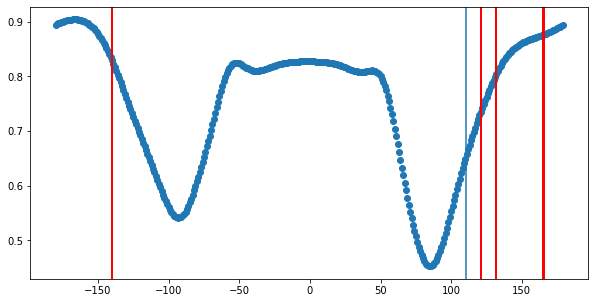

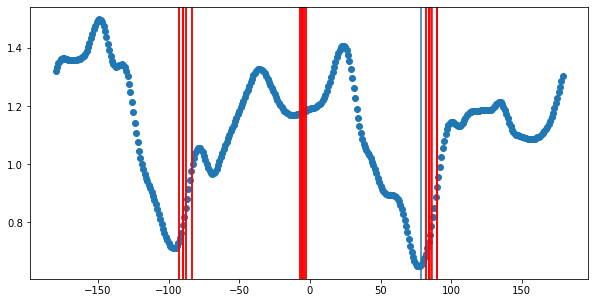

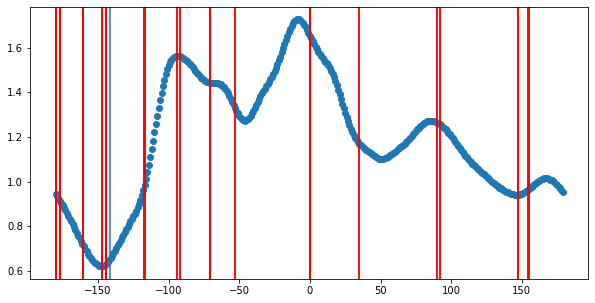

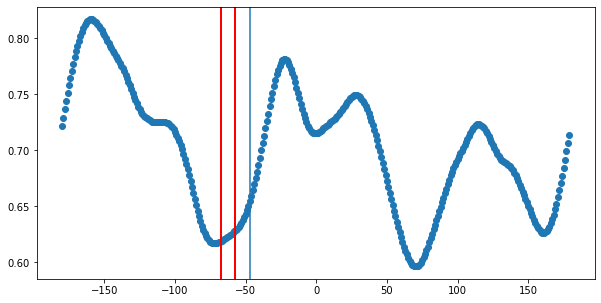

In [15]:
n_gen = new_mol.GetNumConformers() - mol.GetNumConformers()
for torsion_atoms in torsions :
    angles = range(-180, 180, 1)
    explore_data_list = []
    for angle in angles :
        dummy_mol = copy.deepcopy(mol) 
        conf = dummy_mol.GetConformer(0)
        SetDihedralDeg(conf, *torsion_atoms, angle)
        data = conf_to_data(dummy_mol, 0, range(mol.GetNumConformers()), data_list[0].x, data_list[0].edge_index, data_list[0].edge_attr, 'ccdc')
        explore_data_list.append(data)

    explore_batch = Batch.from_data_list(explore_data_list)
    pred_rmsd = litschnet(explore_batch)
    plt.figure(figsize=(10,5))
    plt.scatter(angles, pred_rmsd.detach())
    plt.axvline(GetDihedralDeg(mol.GetConformer(0), *torsion_atoms))
    for conf in new_mol.GetConformers()[-n_gen:] :
        plt.axvline(GetDihedralDeg(conf, *torsion_atoms), c='red')
    plt.show()

In [78]:
torsion_atoms = torsions[0]

In [99]:
angles = range(-180, 180, 1)
explore_data_list = []
for angle in angles :
    dummy_mol = copy.deepcopy(mol) 
    conf = dummy_mol.GetConformer(0)
    SetDihedralDeg(conf, *torsion_atoms, angle)
    data = conf_to_data(dummy_mol, 0, range(mol.GetNumConformers()), data_list[0].x, data_list[0].edge_index, data_list[0].edge_attr, 'ccdc')
    explore_data_list.append(data)
    
explore_batch = Batch.from_data_list(explore_data_list)
pred_rmsd = litschnet(explore_batch)

In [86]:
batch

DataBatch(x=[1323, 81], edge_index=[2, 2842], edge_attr=[2842, 8], pos=[1323, 3], rmsd=[49], tfd=[49], smiles=[49], batch=[1323], ptr=[50])

In [87]:
explore_batch

DataBatch(x=[972, 81], edge_index=[2, 2088], edge_attr=[2088, 8], pos=[972, 3], rmsd=[36], tfd=[36], smiles=[36], batch=[972], ptr=[37])

In [92]:
explore_batch.rmsd

tensor([1.0000e-06, 1.0000e-06, 1.0000e-06, 1.0000e-06, 1.0000e-06, 1.0000e-06,
        1.0000e-06, 1.0000e-06, 1.0000e-06, 1.0000e-06, 1.0000e-06, 1.0000e-06,
        1.0000e-06, 1.0000e-06, 1.0000e-06, 1.0000e-06, 1.0000e-06, 1.0000e-06,
        1.0000e-06, 1.0000e-06, 1.0000e-06, 1.0000e-06, 1.0000e-06, 1.0000e-06,
        1.0000e-06, 1.0000e-06, 1.0000e-06, 1.0000e-06, 1.0000e-06, 1.0000e-06,
        1.0000e-06, 1.0000e-06, 1.0000e-06, 1.0000e-06, 1.0000e-06, 1.0000e-06])

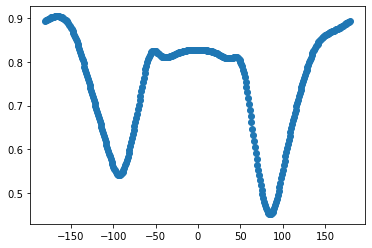

In [100]:
plt.scatter(angles, pred_rmsd.detach())

In [101]:
GetDihedralDeg(mol.GetConformer(0), *torsion_atoms)

110.49084635799547